In [1]:
# import necessary libraries
from __future__ import print_function, division
%matplotlib inline
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
import numpy as np
import pandas as pd
import random
import thinkstats2
import thinkplot
import statsmodels.formula.api as smf

## Exercises

**Exercise:**   The linear model I used in this chapter has the obvious drawback that it is linear, and there is no reason to expect prices to change linearly over time. We can add flexibility to the model by adding a quadratic term, as we did in Section 11.3.

Use a quadratic model to fit the time series of daily prices, and use the model to generate predictions. You will have to write a version of `RunLinearModel` that runs that quadratic model, but after that you should be able to reuse code from the chapter to generate predictions.

In [43]:
# Write a version of RunLinearModel to address a nonlinear relationship. Add quadratric term. 

def RunQuadModel(daily):
    daily['years2'] = daily.years**2
    model = smf.ols('ppg ~ years + years2', data=daily)
    results = model.fit()
    return model, results

In [44]:
# Take the functions that are used to calculate predictions,review and amend to use the quadratic model
    
def SimulateResults(daily, iters=101, func=RunQuadModel):
    _, results = func(daily)
    fake = daily.copy()
    
    result_seq = []
    for _ in range(iters):
        fake.ppg = results.fittedvalues + thinkstats2.Resample(results.resid)
        _, fake_results = func(fake)
        result_seq.append(fake_results)

    return result_seq

def GeneratePredictions(result_seq, years, add_resid=False):
    n = len(years)
    d = dict(Intercept=np.ones(n), years=years, years2=years**2)
    predict_df = pd.DataFrame(d)
    
    predict_seq = []
    for fake_results in result_seq:
        predict = fake_results.predict(predict_df)
        if add_resid:
            predict += thinkstats2.Resample(fake_results.resid, n)
        predict_seq.append(predict)

    return predict_seq

def PlotPredictions(daily, years, iters=101, percent=90, func=RunQuadModel):

    result_seq = SimulateResults(daily, iters=iters, func=func)
    p = (100 - percent) / 2
    percents = p, 100-p

    predict_seq = GeneratePredictions(result_seq, years, add_resid=True)
    low, high = thinkstats2.PercentileRows(predict_seq, percents)
    thinkplot.FillBetween(years, low, high, alpha=0.3, color='gray')

    predict_seq = GeneratePredictions(result_seq, years, add_resid=False)
    low, high = thinkstats2.PercentileRows(predict_seq, percents)
    thinkplot.FillBetween(years, low, high, alpha=0.5, color='gray')

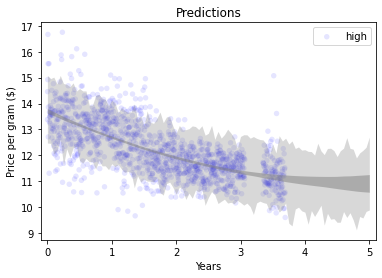

In [45]:
# Prediction plot that incorporates modeling uncertainty (dark grey) predictive uncertainty (light grey) for the nonlinear 
# relationship of price by time

years = np.linspace(0, 5, 101)
thinkplot.Scatter(daily.years, daily.ppg, alpha=0.1, label=name)
PlotPredictions(daily, years)
xlim = years[0]-0.1, years[-1]+0.1
thinkplot.Config(title='Predictions',
                   xlabel='Years',
                   xlim=xlim,
                   ylabel='Price per gram ($)')

**Exercise:** Write a definition for a class named `SerialCorrelationTest` that extends `HypothesisTest` from Section 9.2. It should take a series and a lag as data, compute the serial correlation of the series with the given lag, and then compute the p-value of the observed correlation.

Use this class to test whether the serial correlation in raw price data is statistically significant. Also test the residuals of the linear model and (if you did the previous exercise), the quadratic model.

In [46]:
# Copied over Hypothesis class code to take a look and remind myself what it looks like

class HypothesisTest(object):

    def __init__(self, data):
        self.data = data
        self.MakeModel()
        self.actual = self.TestStatistic(data)

    def PValue(self, iters=1000):
        self.test_stats = [self.TestStatistic(self.RunModel()) 
                           for _ in range(iters)]

        count = sum(1 for x in self.test_stats if x >= self.actual)
        return count / iters

    def TestStatistic(self, data):
        raise UnimplementedMethodException()

    def MakeModel(self):
        pass

    def RunModel(self):
        raise UnimplementedMethodException()

In [48]:
# Create SerialCorrelationTest class that extends the HypothesisTest using series and lag data.
# By taking the absolute value, it will be a two-sided test. The null hypothesis is that there is no correlation 
# between raw price data and time. To model the null hypothesis, i will permute the series data.

class SerialCorrelationTest(thinkstats2.HypothesisTest):

    def TestStatistic(self, data):
        series, lag = data
        test_stat = abs(thinkstats2.SerialCorr(series, lag))
        return test_stat
    
    def RunModel(self):
        series, lag = self.data
        permuted_series = series.reindex(np.random.permutation(series.index))
        return permuted_series, lag

In [64]:
# Run the Hypothesis test to see if the serial correlation in raw price data is statistically significant.
# Using the filled.ppg variable created in the lesson since it's the raw data with NaNs filled in.
sc = SerialCorrelationTest((filled.ppg, 1))
pvalue = sc.PValue()
pvalue

0.0

In [66]:
# Test the residuals of the linear model, once again I will use the residuals of the filled.ppg variable.
sc = SerialCorrelationTest((filled.resid, 1))
pvalue = sc.PValue()
pvalue

0.335

In [62]:
# To test the data from the quadratic model
RunQuadModel(daily)
sc = SerialCorrelationTest((results.resid, 1))
pvalue = sc.PValue()
pvalue

0.009